In [1]:
#https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
#cool code for a button to hide code 
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tabulate
import statistical_tools as s_tools
from scipy.stats import binom, binom_test, chisquare, chi2_contingency
from scipy import stats
#plotting with seaborn
#https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")



##### Titanic data exploration (3) 

So to add to our influencers of survival rate, we will look at 'Fare' and later 'Pclass' both representing the class of the individual. With Fare we might have a chance for a different style assessment, given it is a numberical value. However we you will see that we end up having to change our thoughts on analysis after some earlier exploratory analysis.

So our analysis will include:

<ul>
    <ol>
        <li>Fare <b>Exploration</b></li>
        <li><b>Summary</b>/Thoughts on the data</li>
        <li>Statistical test: <b>Sign test</b> (A variance on the binomial test)</li>  
    </ol>
    <ol>
        <li>Pclass <b>Exploration</b></li>
        <li><b>Summary</b></li>
        <li><b>Chi-Squared</b> test</li>
    </ol>
    
</ul>



In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So reviewing our variables we will again compare survival with Fare. Let's get a visual on the summary statistics, best done in this situation with something like the boxplot.

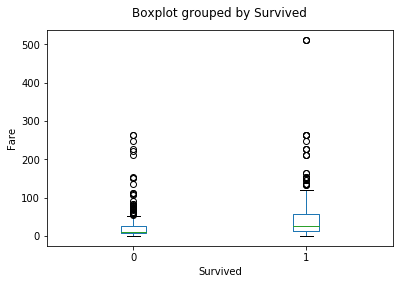

In [3]:
#extract data types so we can select numerical ones
train.boxplot(by ='Survived', column =['Fare'], grid = False) 
plt.ylabel('Fare')
plt.title('')
#sns.swarmplot(x='Survived', y='Fare' ,data=train)
survived = train[train['Survived'] == 1]

Looks like a fair difference on the mean and median betweent he two groups, however we do see some similarities and maybe some heavy inluence form outliers. We can take a quick look at the numbers for each group too.

In [4]:
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]
print('Survived {}\n'.format(survived['Fare'].describe()))
print('Not Survived \n{}'.format(not_survived['Fare'].describe()))

Survived count    342.000000
mean      48.395408
std       66.596998
min        0.000000
25%       12.475000
50%       26.000000
75%       57.000000
max      512.329200
Name: Fare, dtype: float64

Not Survived 
count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64


As we saw on the boxplot, some clear differences in the mean/median, but also the 'max' value difference says somthing about maybe some influence via these extreme outliers. For example, the absolute ultra rich will likely have easily had access to boats, as opposed to say, ppl who are just a normal level of upper-class.

Let's also get a look at this data as a distribution.

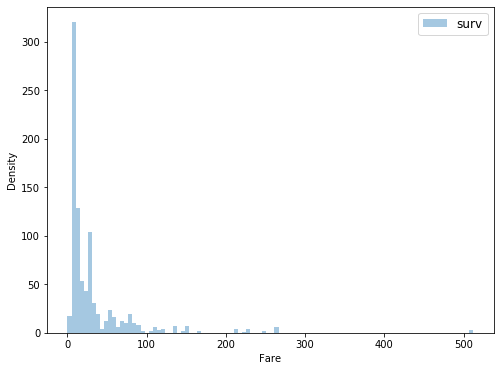

In [5]:
bins = 100
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['Fare'], bins=bins, kde=False, label='surv', ax=ax)

plt.legend(prop={'size': 12})
#plt.title('All passengers ages vs survived passengers')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.show()

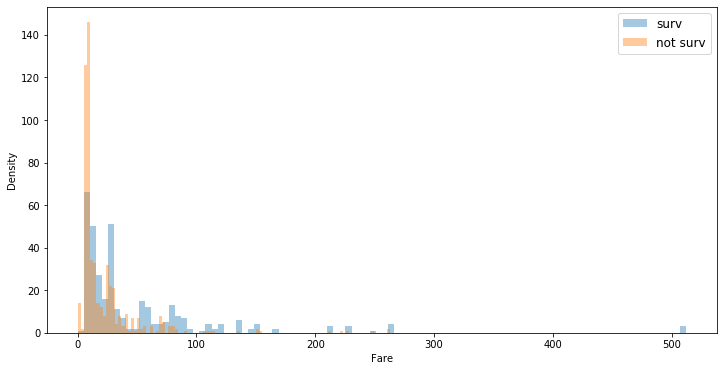

In [6]:

bins = 100
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(survived['Fare'], bins=bins, kde=False, label='surv', ax=ax)
sns.distplot(not_survived['Fare'], bins=bins, kde=False,label='not surv', ax=ax)

plt.legend(prop={'size': 12})
#plt.title('All passengers ages vs survived passengers')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.show()

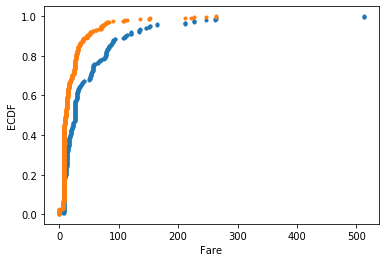

In [7]:

x_surv, y_surv = s_tools.ecdf(survived['Fare'])
x_no_surv, y_no_surv = s_tools.ecdf(not_survived['Fare'])
plt.plot(x_surv, y_surv, marker='.', linestyle='none')
plt.plot(x_no_surv, y_no_surv, marker='.', linestyle='none')
plt.xlabel('Fare')
plt.ylabel('ECDF')

plt.show()

We can clearly see from both our probability distributions and cumulitive distributions that they are far from normal, this makes sense given ticket Fares don't necessarily center around some mean. As expected and as the distributinos show, Ticket Fares are more dense around the cheaper end, that is there is much more economy cabins and cheap rooms than there are rich middle-class or high clas ones.

So the data is not normally distributed, therefore some parametric (normal-distribution assumption) tests will be off limits for us. There are non-parametric tests that I could use, such as the sign-test that might be appropriate. 

Importantly though, I would also say that the **assumption of independent samples is broken** also. That is, having a ship full of rich ppl may affect the survival of poor people, because they will take the survival boats that could have been used by the poor. Or maybe the working class were more industrious? And just took the boats for their own suvival. So in this case we can't really use these test types.

Instead our sampling simulations we have used previously might be better suited, but let's do the sign-test anyway for some fun!
https://www.statisticshowto.com/sign-test/

*Note: My understanding of this test, is that it pretty much converts a numerical value like our Fare into a success or failure, as to enable the use of the binomial test - so pretty much what we've been using anyway!



In [8]:
#sign test
#we will have to only compare equal amoutns so throw away some values from the larger group
end_range = np.min([len(survived), len(not_survived)])


In [9]:

fair_diff = survived['Fare'].iloc[0:end_range].values - not_survived['Fare'].iloc[0:end_range].values
pos = [fair_diff > 0]
neg = [fair_diff < 0]
n = np.sum(pos) + np.sum(neg)
successes =np.sum(pos)
#print(n)
prob_of_res = binom_test(successes, n, 0.5)
print('P-value = {:.20f}'.format(prob_of_res))


P-value = 0.00000000001142703548


In [10]:

survived_rm_outlier = survived[survived['Fare'] != np.max(survived['Fare'])]
end_range = np.min([len(survived_rm_outlier), len(not_survived)])
fair_diff = survived_rm_outlier['Fare'].iloc[0:end_range].values - not_survived['Fare'].iloc[0:end_range].values
pos = [fair_diff > 0]
neg = [fair_diff < 0]
n = np.sum(pos) + np.sum(neg)
successes =np.sum(pos)
#print(n)
prob_of_res = binom_test(successes, n, 0.5)
print('P-value (Extreme outlier removed) = {:.20f}'.format(prob_of_res))


P-value (Extreme outlier removed) = 0.00000002567651248594


A very significant value, that is, a very low probability that higher survival rate we saw in the higher priced fares was due to chance, so was instead potentially due to a trait within this population of higher fare paying groups (Most likely being richer and a higher class!). 

I have also performed the same test with the very expensive outlier Fare removed. And we still a very low p-value.

**But we will take this value with a grain of salt because our assumptions on independence were pretty flimsy!**

##### Chi-squared on PClass 

We could say that class may encompass the advantage of the rich better than our Fare variable, we we will have a look at the signficane of this value on survival rates. This is a categorical variable, thus the Chi-squared test is ideal for testing its significance.

Let's calculate the probability of survival for each class...


Survival probability
1: 0.6296296296296297
2: 0.47282608695652173
3: 0.24236252545824846


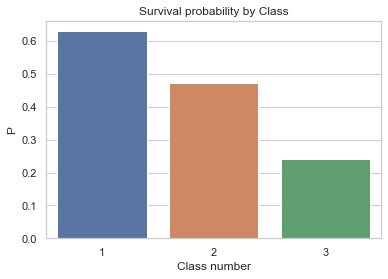

In [15]:
#https://seaborn.pydata.org/examples/grouped_barplot.html
sns.set(style="whitegrid")

survived = train[train['Survived'] == 1]

ones = train[train['Pclass'] == 1]
ones_surv = sum(ones['Survived'] == 1)

twos = train[train['Pclass'] == 2]
twos_surv = sum(twos['Survived'] == 1)

threes = train[train['Pclass'] == 3]
threes_surv = sum(threes['Survived'] == 1)

ones_prob = ones_surv/len(ones)
twos_prob = twos_surv/len(twos)
threes_prob = threes_surv/len(threes)



print('Survival probability\n1: {}\n2: {}\n3: {}'.format(ones_prob, twos_prob, threes_prob))
#print()


df = pd.DataFrame({'Pclass':['1', '2', '3'], 'val':[ones_prob, twos_prob, threes_prob], 'count':[len(ones), len(twos), len(threes)]})
sns.barplot(x = 'Pclass', y = 'val', data = df);
plt.title('Survival probability by Class');
plt.xlabel('Class number');
plt.ylabel('P');

Above is as we had hypothesised, that higher class individuals had an advantage. 

In [25]:
s = pd.DataFrame({'survived': [sum(ones['Survived'] == 1),
                                sum(twos['Survived'] == 1),
                                   sum(threes['Survived'] == 1)],
                  'not survived': [sum(ones['Survived'] == 0),
                                sum(twos['Survived'] == 0),
                                   sum(threes['Survived'] == 0)]})

s = s.transpose()


In [28]:
#https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b
#chi-square independence test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(s)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table (Expected values)===")
print(ex)
print("\n")
print("Observed values")
print(s)

===Chi2 Stat===
102.88898875696057


===Degrees of Freedom===
2


===P-Value===
4.5492517112987287e-23


===Contingency Table (Expected values)===
[[ 82.90909091  70.62626263 188.46464646]
 [133.09090909 113.37373737 302.53535354]]


Observed values
                0   1    2
survived      136  87  119
not survived   80  97  372


The contingency table shows us what survival rates we should have expected, given an equal survival likelihood and given the respective numbers of people in each class. 

We can compare them against the actual observed values below this, there are some clear differences and our very small p-value indicates that there is a significant difference for survival rate between the class category.



In [30]:
exp = ex
exp
obs = np.array(s)
obs

#Chi-square goodness of fit
chisquare(exp, f_exp=obs)

#scipy.stats.chisquare()

Power_divergenceResult(statistic=array([55.958386  ,  5.84551093, 53.52038764]), pvalue=array([7.40213242e-14, 1.56168389e-02, 2.55923087e-13]))

Now (above) we run a goodness of fit test on the observed and expected values, we recieved significant p-values that state these observed results are different to our expected results (given a null hypothesis of no difference within category for survival rate).

Therefore we are very confident that the class level has an effect on survival probability for passengers.